In [17]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

datetime_features = ['dayofweek', 'month', 'hour', 'minute', 'is_weekend']
data = pd.read_parquet("../data/rucphen_precipitation_clean.parquet")

def get_masked_data(df: pd.DataFrame):
    # Define the start and end timestamps
    start_timestamp = pd.to_datetime('2023-01-01 08:00:00')
    end_timestamp = pd.to_datetime('2023-12-31 08:00:00')

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    #filter values that are less then 0 from polygon_1663
    result_df = result_df[result_df['polygon_1663'] >= 0]

    result_df.fillna(0, inplace=True)

    return result_df


def to_input(df: pd.DataFrame):
    df['polygon_1663'].fillna(0, inplace=True)

    return df

data = pd.read_parquet("../data/rucphen_precipitation_clean.parquet")
data = get_masked_data(data)
data = to_input(data)




In [20]:
# Use 'polygon_1663' as the feature of interest
data.set_index('timestamp', inplace=True)

y = data['polygon_1663']

data.head()


,polygon_1663,percentage
timestamp,,
2023-01-01 08:00:00,0.02,7.018
2023-01-01 08:05:00,0.01,7.018
2023-01-01 08:10:00,0.00,7.018
2023-01-01 08:15:00,0.00,7.018
2023-01-01 08:20:00,0.00,7.018


In [21]:
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -25.229313
p-value: 0.000000


In [23]:
split_ratio = 0.8
split_index = int(len(y) * split_ratio)

train = y[:split_index]
test = y[split_index:]


In [29]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 288)) # These parameters might need adjustment
model_fit = model.fit()


c:\Users\Optic\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Optic\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [26]:
# Predict using integer positions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate MSE
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')


c:\Users\Optic\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Optic\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error: 0.005665710003739248


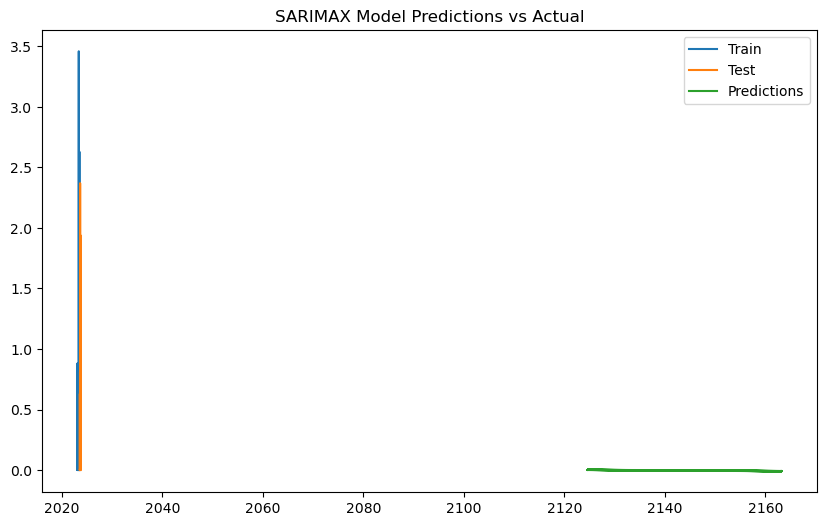

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.title('SARIMAX Model Predictions vs Actual')
plt.legend()
plt.show()


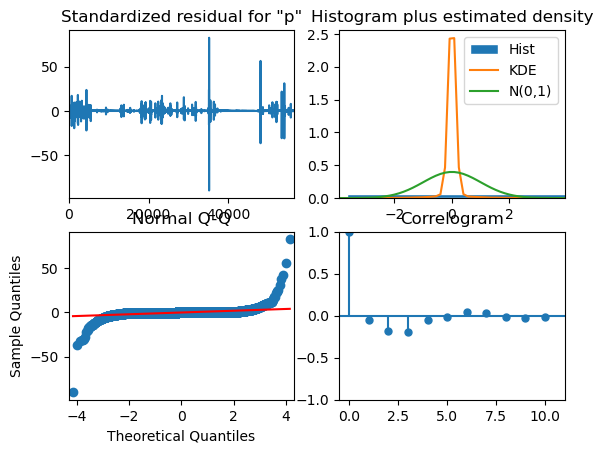

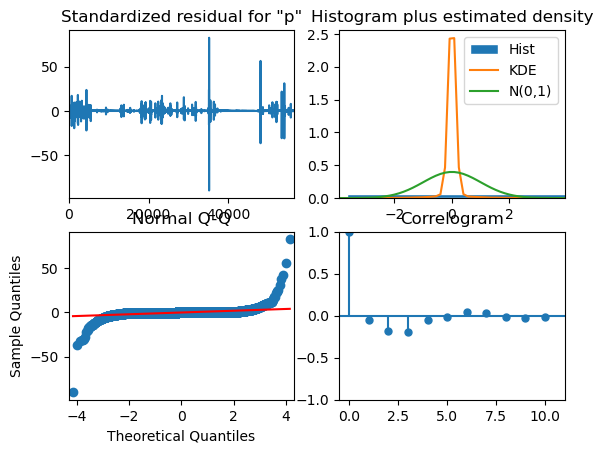

In [28]:
model_fit.plot_diagnostics()
